## AI Lifecycle - Final project
### Modeling
In this project a model to predict a pacific herring's location based on it's otolith shape. The data contains images of otoliths from eight different regions in Alaska. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd drive/My\ Drive/lokaverkefni/Original/

/content/drive/My Drive/lokaverkefni/Original


### Read the data
The training and testing datasets that were created in the data processing notebook are imported in the following chunk.

In [ ]:
model_data = np.load('model_data.npz')
x_train, x_test, y_train, y_test = model_data['x_tr'], model_data['x_te'], model_data['y_tr'], model_data['y_te']
x_val, y_val = model_data['x_val'], model_data['y_val']

### An Image from the training set:

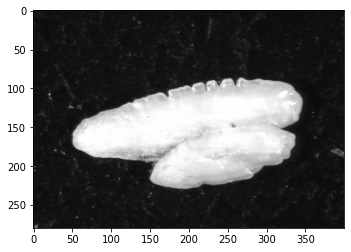

In [ ]:
locations = ['DouglasReef', 'Iniskin', 'Kayak_Island', 'KukakBay', 'Uganik', 'Landlocked',
             'Stockdale', 'RockyBay']
plt.imshow(x_train[0])
plt.show()

### Main model
For the main model we use the VGG16([See this article](https://arxiv.org/abs/1409.1556)) net with pretrained weights. We add a dense layer on top of the net and a output layer.

In [ ]:
model = VGG16(include_top= False, input_shape = x_train.shape[1:],weights = 'imagenet')
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(8, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)

#### Freeze first layers of the network.

In [ ]:
for i, layer in enumerate(model.layers):
  if i > 10:
    break
  layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 280, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 280, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 280, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 140, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 140, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 140, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 70, 100, 128)      0     

### Model training
To prevent overfitting we use early stopping and we restore the weights from the best epoch according to validation accuracy.

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max',patience = 15, restore_best_weights = True) # stop condition

batch_size = 64
num_epochs = 60

model.compile(loss='sparse_categorical_crossentropy',
  optimizer=Adadelta(),
  metrics=['accuracy'])                                          
                                                                                                                                                                                                                                                 
history = model.fit(x_train, y_train,          
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),callbacks=[es])

Epoch 1/60
135/135 [==============================] - 89s 470ms/step - loss: 1.8202 - accuracy: 0.3339 - val_loss: 1.2296 - val_accuracy: 0.5809
Epoch 2/60
135/135 [==============================] - 56s 417ms/step - loss: 0.9493 - accuracy: 0.7058 - val_loss: 0.8243 - val_accuracy: 0.6912
Epoch 3/60
135/135 [==============================] - 56s 418ms/step - loss: 0.5333 - accuracy: 0.8262 - val_loss: 0.6722 - val_accuracy: 0.7868
Epoch 4/60
135/135 [==============================] - 56s 418ms/step - loss: 0.3419 - accuracy: 0.8923 - val_loss: 0.5823 - val_accuracy: 0.7941
Epoch 5/60
135/135 [==============================] - 56s 418ms/step - loss: 0.2436 - accuracy: 0.9351 - val_loss: 0.5357 - val_accuracy: 0.8235
Epoch 6/60
135/135 [==============================] - 56s 418ms/step - loss: 0.1866 - accuracy: 0.9535 - val_loss: 0.6377 - val_accuracy: 0.8088
Epoch 7/60
135/135 [==============================] - 56s 418ms/step - loss: 0.1545 - accuracy: 0.9655 - val_loss: 0.4787 - val_ac

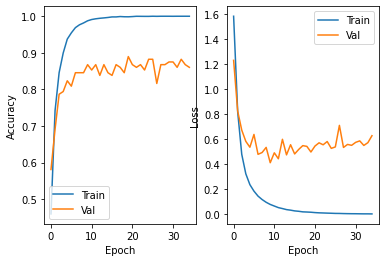

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print(f'test accuracy: {score[1]}')
model.save('model_gray_1')

5/5 [==============================] - 7s 488ms/step - loss: 0.6362 - accuracy: 0.7778
test accuracy: 0.7777777910232544
INFO:tensorflow:Assets written to: model_gray_1/assets


#### Model performance - Confusion Matrix
Here we display the confusion matrix for the test set.

[[19  8  0  0  1  0  1  0]
 [ 1 15  2  0  0  0  0  0]
 [ 0  8 14  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0]
 [ 0  0  0  0  8  0  1  0]
 [ 0  0  0  0  0 14  0  2]
 [ 0  0  4  0  0  0  4  0]
 [ 0  0  0  0  0  2  0  6]]


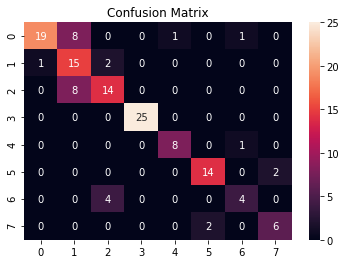

In [ ]:
locations = ['Douglas Reef', 'Iniskin Bay', 'Kayak Island', 'Kukak Bay', 'Uganik Bay', 'Landlocked Bay',
             'Stockdale Harbor', 'Rocky Bay']

y_pred = np.argmax(model.predict(x_test), axis = 1)
conf_mat = confusion_matrix(y_test, y_pred)

print(conf_mat)

ax = plt.subplot()
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(locations)
ax.yaxis.set_ticklabels(locations)
sns.heatmap(conf_mat, annot=True)
plt.show()

#### Explainability

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer()

Region: Iniskin Bay


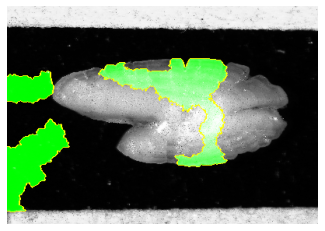



Region: Iniskin Bay


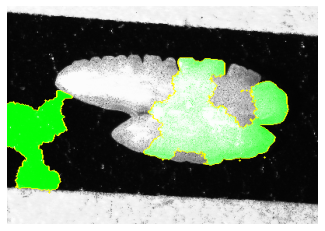



Region: Kukak Bay


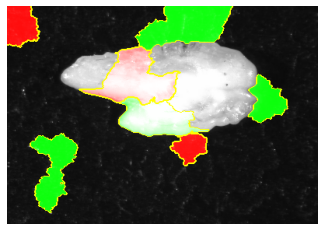



Region: Uganik Bay


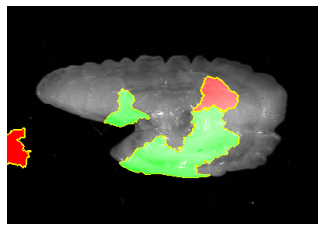



Region: Iniskin Bay


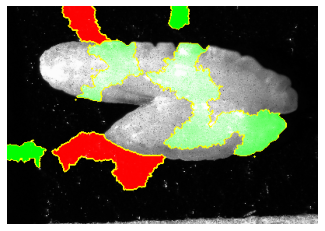



Region: Kukak Bay


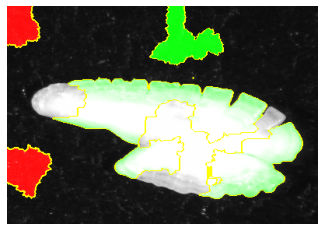



Region: Douglas Reef


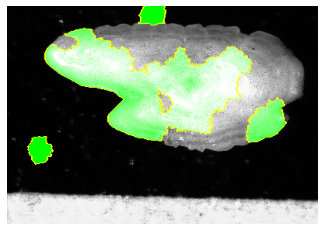



Region: Stockdale Harbor


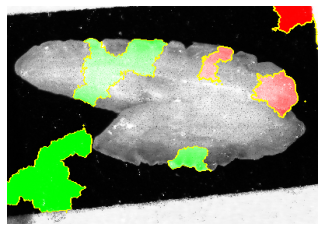



Region: Landlocked Bay


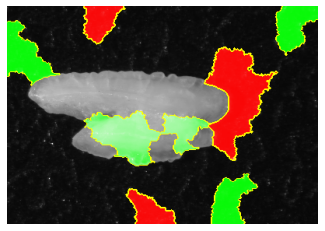



Region: Douglas Reef


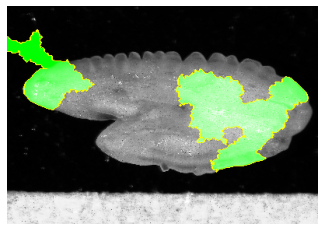

In [ ]:
for i in range(10):
  print(f'Region: {locations[y_test[i]]}')
  explanation = explainer.explain_instance(x_test[i].astype('double'), model.predict,
                                            top_labels = 1, num_samples = 1000)
  
  temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

  plt.imshow(mark_boundaries(temp_2, mask_2))
  plt.axis('off')
  plt.show()
  print('\n')
  

#### Base Model
Here we try to build a simple convolutional neural network and compare the performance of that model to the deep network that was trained earlier.

In [ ]:
# simple model

num_classes = 8

model_b = Sequential()
model_b.add(Conv2D(32, kernel_size= (3,3),
                   activation = 'relu',
                   input_shape = x_train.shape[1:], padding='same'))
model_b.add(Conv2D(32,  kernel_size = (3,3),
                 activation='relu',padding='same'))

model_b.add(MaxPooling2D(pool_size=(2,2)))
model_b.add(Conv2D(64, (3,3),activation='relu', padding='same'))
model_b.add(Conv2D(64, (3,3),activation='relu', padding='same'))


model_b.add(Flatten())
model_b.add(Dropout(0.25))
model_b.add(Dense(num_classes, activation='softmax'))

model_b.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 280, 400, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 280, 400, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 140, 200, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 140, 200, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 140, 200, 64)      36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1792000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1792000)           0

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max',patience = 40, restore_best_weights = True)

model_b.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

history=model_b.fit(x_train, y_train,
                  batch_size=32,
                  epochs=200,
                  verbose=1,
                  validation_data=(x_val, y_val))
print('....\n')
score = model_b.evaluate(x_test, y_test, verbose=1)
model_b.save('model_simple_gray')

Epoch 1/400
269/269 [==============================] - 37s 128ms/step - loss: 1.9287 - accuracy: 0.2593 - val_loss: 2.0509 - val_accuracy: 0.2059
Epoch 2/400
269/269 [==============================] - 32s 121ms/step - loss: 1.6535 - accuracy: 0.3844 - val_loss: 2.5628 - val_accuracy: 0.2206
Epoch 3/400
269/269 [==============================] - 33s 121ms/step - loss: 1.5453 - accuracy: 0.4082 - val_loss: 3.0926 - val_accuracy: 0.2206
Epoch 4/400
269/269 [==============================] - 32s 121ms/step - loss: 1.4954 - accuracy: 0.4253 - val_loss: 3.4226 - val_accuracy: 0.2206
Epoch 5/400
269/269 [==============================] - 33s 121ms/step - loss: 1.4669 - accuracy: 0.4283 - val_loss: 3.6403 - val_accuracy: 0.2426
Epoch 6/400
269/269 [==============================] - 33s 121ms/step - loss: 1.4256 - accuracy: 0.4513 - val_loss: 3.9419 - val_accuracy: 0.2279
Epoch 7/400
269/269 [==============================] - 33s 121ms/step - loss: 1.4205 - accuracy: 0.4441 - val_loss: 4.1005 -

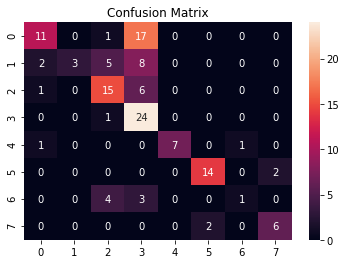

In [ ]:
y_pred = np.argmax(model_b.predict(x_test), axis = 1)


conf_mat = confusion_matrix(y_test, y_pred)


ax = plt.subplot()
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(locations)
ax.yaxis.set_ticklabels(locations)
sns.heatmap(conf_mat, annot=True)
plt.show()

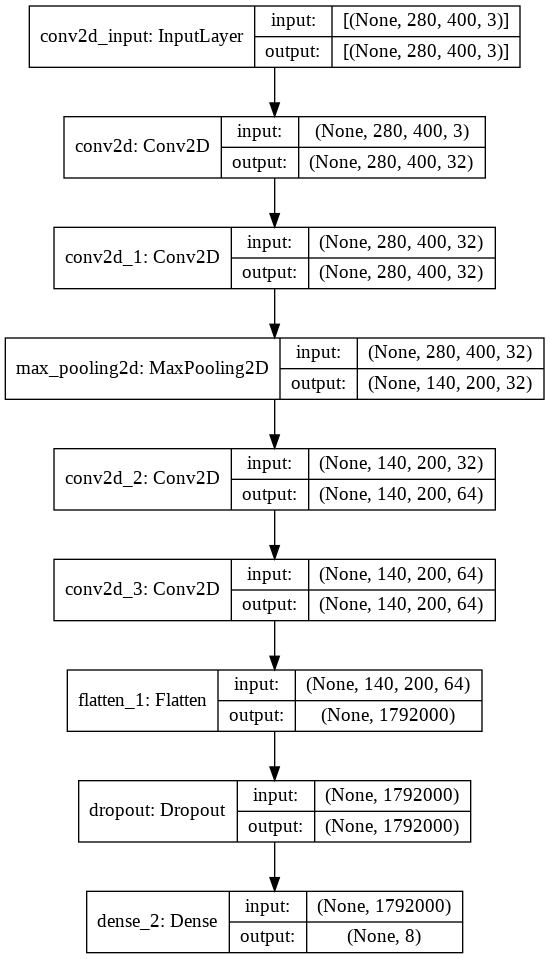

In [ ]:
# plot simple model architecture
plot_model(model_b, to_file='model_base.png', show_shapes=True)